### Example of export rough fracture into various model format(cad,stl,etc)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pyvista as pv

# setting path
import sys
sys.path.append(r'../parentdirectory')
sys.path.append(r'..')

from digifrac import *
import gc
import tifffile as tif
import open3d as o3d
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tifffile import imwrite

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Image_seg(This case is only for demonstration purposes. To improve the accuracy of image segmentation, it is necessary to increase the amount of training data)

In [2]:
# File path and data information
file_path = "../data/example.tif"

ct_data = CTImageSegmenter.load_data(file_path)

# Print data attributes
print(f"Loaded CT data shape: {ct_data.shape}, dtype: {ct_data.dtype}")

Loading .tif file...
Data loaded with shape (82, 97, 81).
Loaded CT data shape: (82, 97, 81), dtype: uint16


In [3]:
# Extract slice
slice_index = 60
slice_data = ct_data[:, slice_index, :]

# Save as TIFF file
output_path = f"training_data/slice_{slice_index:03d}.tif"
imwrite(output_path, slice_data)
print(f"Slice {slice_index} saved as {output_path}")

Slice 60 saved as training_data/slice_060.tif


In [4]:
# Labelme annotations
image_files = [
    "training_data/slice_060.tif",

]
json_files = [
    "training_data/slice_060.json",

]

# Feature extraction parameters
sigma_min, sigma_max = 1, 16

# Initialize lists to store features and labels
features_list = []
labels_list = []

# Process each pair of image and JSON file
for image_file, json_file in zip(image_files, json_files):
    features, labels = CTImageSegmenter.generate_training_data_from_json(
        image_file, json_file, sigma_min, sigma_max
    )
    features_list.append(features)
    labels_list.append(labels)

# Train the segmenter
model_path = "training_data/segmenter.pkl"
clf = CTImageSegmenter.train_segmenter_from_features(features_list, labels_list, model_path=model_path)


Model saved to training_data/segmenter.pkl


In [5]:
# Extract a slice from 3D CT data
slice_index = 35  # Replace with the desired slice index
new_slice = CTImageSegmenter.extract_single_slice(ct_data, slice_index)

# Perform segmentation using the trained segmenter
sigma_min, sigma_max = 1, 16  # Must match training parameters
segmented_result = CTImageSegmenter.segment_ct_slice(ct_data, clf, slice_index, sigma_min, sigma_max)

# Binarize the segmentation result
binary_segmented_result = np.zeros_like(segmented_result, dtype=np.uint8)
binary_segmented_result[segmented_result == 1] = 1  # Label = 1 set to 1
binary_segmented_result[segmented_result != 1] = 0  # Other labels set to 0

Slice 35 extracted and saved to training_data\slice_035.tif
Extracted slice 35 with shape: (97, 81)


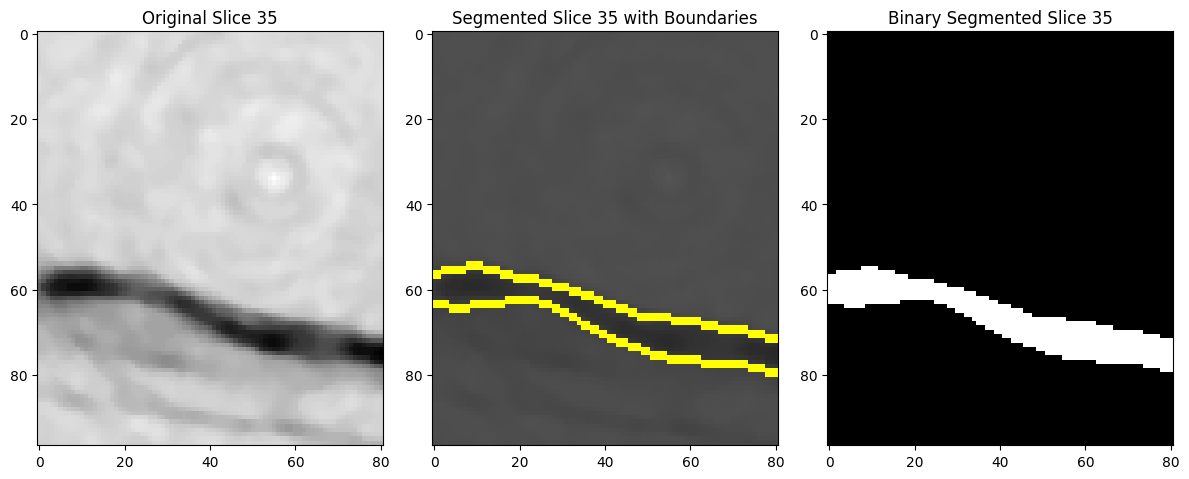

In [6]:
# Visualize results
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

plt.figure(figsize=(12, 8))

# Original slice
plt.subplot(1, 3, 1)
plt.imshow(new_slice, cmap='gray')
plt.title(f"Original Slice {slice_index}")

# Original slice with segmentation boundaries
plt.subplot(1, 3, 2)
plt.imshow(mark_boundaries(new_slice, segmented_result, mode='thick'))
plt.title(f"Segmented Slice {slice_index} with Boundaries")

# Binarized result
plt.subplot(1, 3, 3)
plt.imshow(binary_segmented_result, cmap='gray')
plt.title(f"Binary Segmented Slice {slice_index}")

plt.tight_layout()
plt.show()

In [7]:
# Perform segmentation using the trained segmenter
output_3d_path = "Results/example_seg_result.tif"
binary_segmented_3d_result = CTImageSegmenter.segment_3d_binary_and_save(
    ct_data, clf, sigma_min=1, sigma_max=16, output_path=output_3d_path
)

Segmenting 3D CT Data: 100%|██████████| 82/82 [00:02<00:00, 31.92it/s]


### Image process

In [8]:
file_path = "../data/core3d_4fracs.tif"

# img = pv.read(file_path)
img = load_img(file_path)

Loading .tif file...
Data loaded with shape (361, 206, 200) and pad with 5 voxel.


In [9]:
save_img(img, 'Results/origin_image.vti')

3D array saved to 'Results/origin_image.vti' as VTI with dtype: uint8.


In [10]:
img_cleaned = trim_small_clusters(img, size=1000)
print("Number of nonzero voxels before cleaning:", np.count_nonzero(img))
print("Number of nonzero voxels after cleaning:", np.count_nonzero(img_cleaned))
save_img(img_cleaned, 'Results/cleand_image.vti')

Find 4 clusters:
Trimed 4 clusters, left 1 clusters
Number of nonzero voxels before cleaning: 389416
Number of nonzero voxels after cleaning: 389412
3D array saved to 'Results/cleand_image.vti' as VTI with dtype: uint8.


### Fracture complexity analysis

In [11]:
concentration_value = calculate_concentration(img_cleaned)
print(f"concentration_value: {concentration_value}")

concentration_value: 0.8043832362668897


In [12]:
fractal_dimension_value, box_sizes, counts, coeffs, r_squared = fractal_dimension(img_cleaned)
print(f"FD: {fractal_dimension_value}")
print(f"R-squared: {r_squared}")

FD: 2.2143574835761735
R-squared: 0.9984334223833706


In [13]:
fracture_complexity = calculate_fracture_complexity(img_cleaned)
print(f"fracture_complexity: {fracture_complexity}")

fracture_complexity: 2.4689723636320045


In [14]:
point_cloud = voxel_to_point_cloud(img_cleaned)

H_value = Hopkins_Skellam_Index(point_cloud)
print(f"H-index: {H_value}")

H-index: 0.974634468553895


### Fracture skeletonization

In [15]:
img_info = pv.read("Results/image_info.vti")
print('The full version requires the corresponding author to be contacted by email and a usage agreement signed')

The full version requires the corresponding author to be contacted by email and a usage agreement signed


### Find intersection pixels and points

In [16]:
img_dim = np.array(img_info.dimensions)-1
img_skel = img_info['skel'].reshape(img_dim, order='F')
pcd_pv = img2pcd(img_skel,return_pv=True)
point_cloud = pcd_pv.points

In [17]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud)

# Optionally, you can color the points (e.g., blue)
pcd.paint_uniform_color([0, 0, 1])  # Blue color

distances = pcd.compute_nearest_neighbor_distance()
average_distance = np.mean(distances)
print("Average distance between points: {:.4f}".format(average_distance))

Average distance between points: 1.0679


In [18]:
# Find abnormal points using neighboring normals iteratively
print('The full version requires the corresponding author to be contacted by email and a usage agreement signed')
pcd_pv = pv.read("Results/pcd_info.vtp")
pcd_points = np.array(pcd_pv.points)
pcd_flag = pcd_pv["flag"]

The full version requires the corresponding author to be contacted by email and a usage agreement signed


In [19]:
abormal_points = np.asarray(pcd.points)[pcd_flag == 1]
abormal_mask = pcd2img(abormal_points, img_dim)

img_abnormal = np.zeros_like(img_skel,dtype=np.uint8)
img_abnormal[img_skel>0]=1
img_abnormal[abormal_mask>0]=0

img_info['skel_clean'] = img_abnormal.flatten(order='F')
img_info.save("Results/img_skel_info.vti")

In [20]:
from skimage import morphology

img_skel_clean= morphology.remove_small_objects(img_abnormal>0, 1000,connectivity=2)

print("Number of abnormal points: ", np.sum(img_abnormal),np.sum(img_skel_clean))
save_img(img_skel_clean, "Results/img_skel_clean.vti")

Number of abnormal points:  70827 68716
3D array saved to 'Results/img_skel_clean.vti' as VTI with dtype: uint8.


In [21]:
#Further skeleton cleaning
pcd.estimate_normals()
abormal_points = np.asarray(pcd.points)[pcd_flag == 1]

vec = np.asarray(pcd.normals)
points = np.asarray(pcd.points)
_, _, deleted_indices = filter_with_dbscan(vec, eps=0.001, min_samples=20)

abnormal_dbscan_points = points[deleted_indices]

abnormal_dbscan_mask = pcd2img(abnormal_dbscan_points, img_dim)

img_skel_clean[abnormal_dbscan_mask > 0] = 0
mask_skel_clean = img_skel_clean > 0 

### Fracture width

In [22]:
data = img_cleaned > 0

In [23]:
T = local_thickness(data, scale=0.8)

In [24]:
#Map thickness map to fracture medial surface
T_raw=T[T>0]

mask_skel_clean[T==0]=0 # Remove zero thickness in field
img_skel_clean[~mask_skel_clean]=0
T_medial=T[mask_skel_clean]

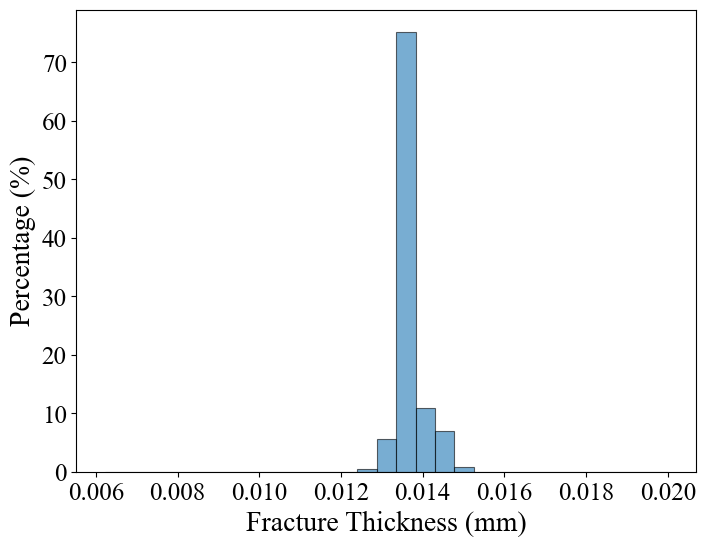

In [25]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20 
plt.rcParams['xtick.labelsize'] = 18  
plt.rcParams['ytick.labelsize'] = 18  
plt.rcParams['legend.fontsize'] = 18  
resolution = 0.0061  # mm
T_raw_mm = T_raw * resolution
T_medial_mm = T_medial * resolution


bins = np.linspace(np.min(np.concatenate((T_raw_mm, T_medial_mm))),
                   np.max(np.concatenate((T_raw_mm, T_medial_mm))),
                   30)


hist_raw, _ = np.histogram(T_raw_mm, bins=bins)
hist_medial, _ = np.histogram(T_medial_mm, bins=bins)


hist_raw = hist_raw / np.sum(hist_raw) * 100  
hist_medial = hist_medial / np.sum(hist_medial) * 100 


bin_centers = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0]) * 1  

plt.figure(figsize=(8, 6))
plt.bar(bin_centers, hist_medial, width=width, alpha=0.6, edgecolor='black', linewidth=0.8)

plt.xlabel('Fracture Thickness (mm)')
plt.ylabel('Percentage (%)') 

plt.show()


### Fracture orientation analysis

In [26]:
MidialSurface_Pts=np.array(np.where(img_skel_clean==True)).T

pcd_skel = o3d.geometry.PointCloud()
pcd_skel.points = o3d.utility.Vector3dVector(MidialSurface_Pts)

o3d.visualization.draw_geometries([pcd_skel])

In [27]:
downpcd = pcd_skel.voxel_down_sample(voxel_size=3)
# o3d.visualization.draw_geometries([downpcd])

In [28]:
downpcd.estimate_normals()
downpcd.paint_uniform_color([0.9, 0.1, 0.1])  # Red

bbox = downpcd.get_axis_aligned_bounding_box()

# Reference Ball
NormalPts = o3d.geometry.TriangleMesh.create_sphere(radius=10.0)
NormalPts.compute_vertex_normals()
NormalPts.paint_uniform_color([0.1, 0.9, 0.1])

# NormalRefPoint = np.array([-20, 30, 10])
NormalRefPoint = np.array([800, 300, 150])
NormalPts.translate(NormalRefPoint)

# Normal vector needs to be reoriented
downpcd.orient_normals_towards_camera_location(camera_location=NormalRefPoint)

# Create coordinate system
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=250,  # Length of the axes
    origin=[0, -50, 0]  # Origin of the coordinate system
)

# Visualize point cloud, sphere, and coordinate system
o3d.visualization.draw_geometries(
    [downpcd, NormalPts, coordinate_frame],
    point_show_normal=True
)

In [29]:
import numpy as np
import pyvista as pv

vec = np.asarray(downpcd.normals)
points = np.asarray(downpcd.points)

filtered_vec, cluster_labels, deleted_indices = filter_with_dbscan(vec, eps=0.025, min_samples=20)

pcd_dbscan = np.zeros(len(points), dtype=np.uint8)
pcd_dbscan[deleted_indices] = 1  

pcd_pv_dbscan = pv.PolyData(points)
pcd_pv_dbscan["flag"] = pcd_dbscan

pcd_pv_dbscan.save("Results/pcd_info_dbscan.vtp")

In [30]:
orientation = calculate_orientation(filtered_vec)

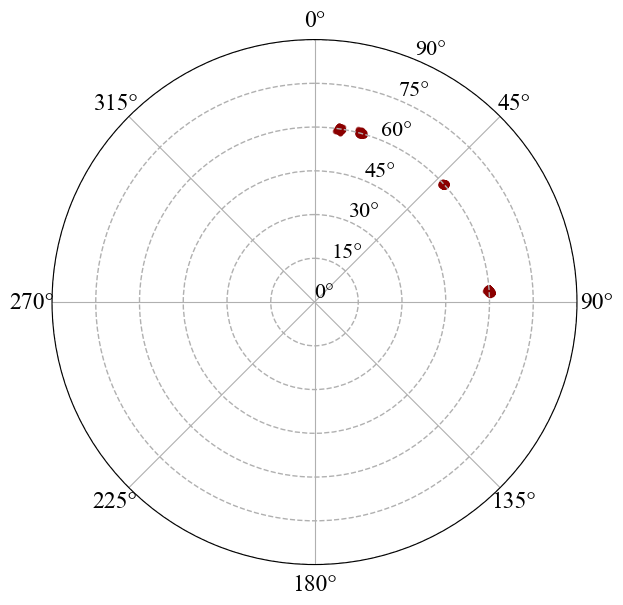

In [31]:
rcParams['font.family'] = 'Times New Roman'

def plot_stereonet(dip, dip_direction):
    dip_direction_rad = np.radians(np.mod(dip_direction, 360))

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})
    ax.set_theta_zero_location('N')  # Set 0° at the top
    ax.set_theta_direction(-1) 

    ax.scatter(dip_direction_rad, dip, color='darkred', s=10, alpha=0.5, linewidth=1)

    ax.set_thetagrids(range(0, 360, 45), fontsize=17)

    radial_lines = ax.yaxis.get_gridlines()
    for line in radial_lines:
        line.set_linestyle('--')
        line.set_linewidth(1)
        line.set_alpha(1)

    radial_ticks = np.arange(0, 91, 15)  # Tick values from 0 to 90
    radial_labels = [f"{tick}°" for tick in radial_ticks]  # Add "°" to each tick
    ax.set_yticks(radial_ticks)
    ax.set_yticklabels(radial_labels, fontsize=16)  # Set font size for radial labels

    fig.tight_layout(pad=0)
    plt.show()

dip = orientation['Dip']
dip_direction = orientation['Dip-Direction']

plot_stereonet(dip, dip_direction)